In [1]:
%matplotlib inline
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt

from tools import flare_model_v2

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
def find_times(time,t,w,h,ypt, fwd=False):
    ftmp = flare_model_v2(time,t,w,h)
    if fwd:
        side = np.where((time >= time[np.argmax(ftmp)]))[0]
    else:
        side = np.where((time < time[np.argmax(ftmp)]))[0]
        
    xpt = np.argmin(np.abs(ftmp[side]-ypt))
    
    output = t-time[side[xpt]]
    return output

(-2.0, 9.0)

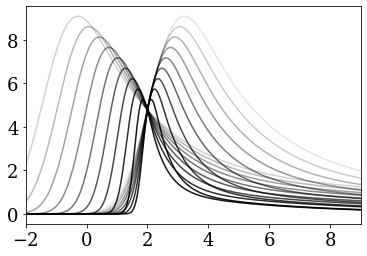

In [25]:
time = np.arange(-3,10,0.01)

fmodel=flare_model_v2(time,2,0.5,5)
ypt = max(fmodel)
xpt = time[np.argmax(fmodel)]

for k in range(1,10):
    width = 0.5 + k/3
    ampl = 5+k/2
    plt.plot(time, flare_model_v2(time, 2+find_times(time,2, width,ampl, ypt,fwd=False), 
                                  width,ampl), c='k', alpha=1-k/10 )
    plt.plot(time, flare_model_v2(time, 2+find_times(time,2, width,ampl, ypt,fwd=True), 
                                  width,ampl), c='k', alpha=1-k/11 )

# plt.plot(time + (2-xpt), fmodel, lw=2, c='r')


plt.xlim(-2,9)
# plt.savefig('flare_butterfly.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')

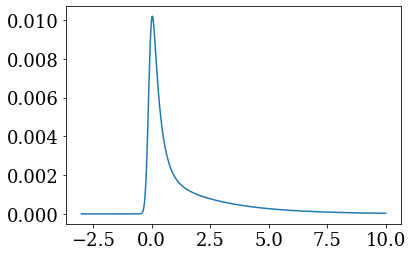

In [47]:
time = np.arange(-3,10,0.01)
fmodel=flare_model_v2(time,0,.5,1)
# print(np.trapz(fmodel, x=time))
# print(sum(fmodel / np.trapz(fmodel, x=time)))
plt.plot(time, fmodel / np.sum(fmodel))

In [65]:
# pseudo Equiv Dur in this makebelieve data
ed = np.trapz(fmodel, x=time*86400)
np.log10(ed)

# set an arbitrary Luminosity for this star, for example
logLUM = 27.

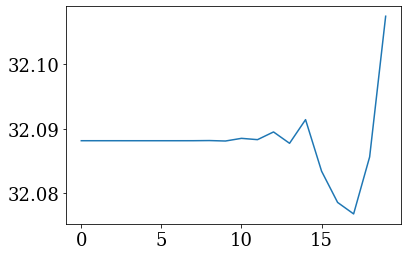

In [66]:
# flare energy is fairly insensitive to sampling... thats good
eng = np.zeros(20)
for k in range(20):
    time = np.arange(-3,10,0.01 + 0.01*k)
    fmodel=flare_model_v2(time,0,0.25,3)
    eng[k] = logLUM + np.log10(np.trapz(fmodel, x=time*86400))
    
plt.plot(eng)

In [174]:
# need a couple simplifying functions to simulate flares:

def energy2fwhm(E):
    # ---> improve this w/ real data!
    # rough idea: logE=28, fwhm=1min
    #             logE=35, fwhm=100min
    
    m=(200/60/24 - .5/60/24) / (35-28)
    b = .5/60/24 - m*28
    fwhm = m*E + b
    return np.abs(fwhm)+0.05/60/24


def energy2ampl(E):
    # ---> improve this w/ real data!
    # rough idea: logE=28, ampl=0.01
    #             logE=35, ampl=1.75
    
    m=(3.75-0.003) / (35-28)
    b = 0.003 - m*28.
    ampl = m*E + b
    return np.abs(ampl)+0.001


def find_prob(time,fmodel,xpt,ypt):
    if np.nanmax(fmodel) < ypt:
        return 0.
    
    prob = fmodel / np.nansum(fmodel)

    int1 = np.argmin(np.abs(fmodel[np.where((time<=xpt))[0]] - ypt))
    prob1 = prob[np.where((time<=xpt))[0]][int1]

    int2 = np.argmin(np.abs(fmodel[np.where((time>xpt))[0]] - ypt))
    prob2 = prob[np.where((time>xpt))[0]][int2]

    return prob1+prob2


def find_dt(time,ftmp,ypt, fwd=False):
#     ftmp = flare_model_v2(time,t,w,h)
    if fwd:
        side = np.where((time >= time[np.argmax(ftmp)]))[0]
    else:
        side = np.where((time < time[np.argmax(ftmp)]))[0]
        
    xpt = np.argmin(np.abs(ftmp[side]-ypt))
    
    output = 0-time[side[xpt]]
    return output

29.5 43.3000000000002 0.8069285714285718 30.598100007210185
0.0020000000016704433 0.7715218870986635


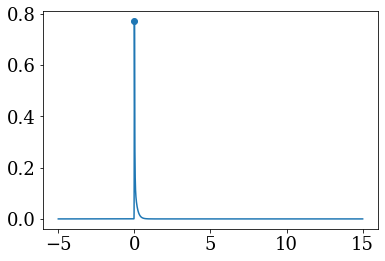

In [223]:
time = np.arange(-5,15,0.001)

approx_e = 29.5
ampl_k = energy2ampl(approx_e)
width_k = energy2fwhm(approx_e)

# baseline flare model 
base_fmodel = flare_model_v2(time, 0, width_k, ampl_k)
# base_energy = logLUM + np.log10(np.trapz(fmodel, x=time*86400))
base_energy = logLUM + np.log10(np.nansum(base_fmodel) * (0.001*86400))
print(approx_e, width_k*60*24, ampl_k, base_energy)

# use peak as the outlier
ypt = max(base_fmodel)
xpt = time[np.argmax(base_fmodel)]

print(xpt,ypt)
plt.plot(time,base_fmodel)
plt.scatter(xpt,ypt)


/Users/james/Dropbox/research_projects/eralf/tools.py:41: RuntimeWarning: overflow encountered in exp
  flare = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t_new)) + ((C**2 * D1**2)/4))*(erf(z1) - erf(z1 - (t_new/C))))
/Users/james/Dropbox/research_projects/eralf/tools.py:42: RuntimeWarning: overflow encountered in exp
  + (f2 * np.exp((D2*(B-t_new)) + ((C**2 * D2**2)/4))*(erf(z2) - erf(z2 - (t_new/C)))))
/Users/james/Dropbox/research_projects/eralf/tools.py:42: RuntimeWarning: invalid value encountered in multiply
  + (f2 * np.exp((D2*(B-t_new)) + ((C**2 * D2**2)/4))*(erf(z2) - erf(z2 - (t_new/C)))))


(-0.5, 1.0)

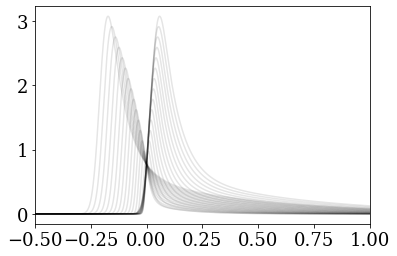

In [224]:
# run simulation of an outlier point for this star, scan over energies
# do COARSE for butterfly viz...

# energy of flares to consider
energy_0 = np.linspace(28.,34, 20)
# probability computed for each event
probs = np.zeros_like(energy_0)
# i'm making up transformations, so the simulated energy != energy that results...
energy = np.zeros_like(energy_0)

for k in range(len(energy)):
    ampl_k = energy2ampl(energy_0[k])
    width_k = energy2fwhm(energy_0[k])
    fmodel_k = flare_model_v2(time, 0, width_k, ampl_k)
    energy[k] = logLUM + np.log10(np.trapz(fmodel_k, x=time*86400))
    
    probs[k] = find_prob(time, fmodel_k,xpt,ypt)
    
#     plt.plot(time, fmodel_k, alpha=0.1, c='k')
    if np.nanmax(fmodel_k)>ypt:
        plt.plot(time, flare_model_v2(time, find_dt(time,fmodel_k, ypt,fwd=False), 
                                      width_k,ampl_k), c='k', alpha=.1)
        plt.plot(time, flare_model_v2(time, find_dt(time,fmodel_k, ypt,fwd=True), 
                                      width_k,ampl_k), c='k', alpha=.1 )

# plt.plot(time,base_fmodel)
plt.xlim(-.5,1)


30.598100007210185 0.19864962443846323


/Users/james/Dropbox/research_projects/eralf/tools.py:42: RuntimeWarning: overflow encountered in exp
  + (f2 * np.exp((D2*(B-t_new)) + ((C**2 * D2**2)/4))*(erf(z2) - erf(z2 - (t_new/C)))))
/Users/james/Dropbox/research_projects/eralf/tools.py:42: RuntimeWarning: invalid value encountered in multiply
  + (f2 * np.exp((D2*(B-t_new)) + ((C**2 * D2**2)/4))*(erf(z2) - erf(z2 - (t_new/C)))))


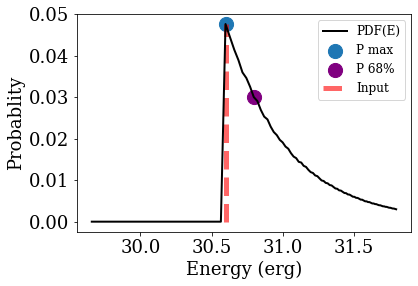

In [230]:
# run simulation of an outlier point for this star, scan over energies

# energy of flares to consider
energy_0 = np.linspace(28.5,34, 100)
# probability computed for each event
probs = np.zeros_like(energy_0)
# i'm making up transformations, so the simulated energy != energy that results...
energy = np.zeros_like(energy_0)

for k in range(len(energy)):
    ampl_k = energy2ampl(energy_0[k])
    width_k = energy2fwhm(energy_0[k])
    fmodel_k = flare_model_v2(time, 0, width_k, ampl_k)
    energy[k] = logLUM + np.log10(np.nansum(fmodel_k) * (0.001*86400))
    
    probs[k] = find_prob(time, fmodel_k,xpt,ypt)

probs = probs /np.sum(probs)

plt.figure()
plt.plot(energy,probs, lw=2,c='k', label='PDF(E)')

plt.scatter(energy[np.argmax(probs)], np.nanmax(probs), c='C0',s=200, label='P max')

eup = np.where(probs <= 0.68*np.nanmax(probs))[0]
err = np.argmax(probs[eup])
plt.scatter(energy[eup][err], 
            probs[eup][err], c='purple', s=200, label='P 68%')

print(energy[np.argmax(probs)], np.abs(energy[np.argmax(probs)] - energy[eup][err]))
plt.vlines(base_energy,0, np.nanmax(probs), color='r', lw=5, alpha=0.6, ls='--',label='Input')
plt.xlabel('Energy (erg)')
plt.ylabel('Probablity')
plt.legend(fontsize=12)
# so the most probable energy is the input one (good!), with a slow tail

<ErrorbarContainer object of 3 artists>

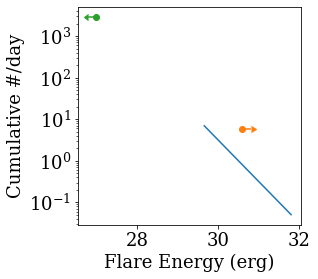

In [249]:
# lets go back to the old idea of taking an FFD, generating a fake lightcurve

# this should reduce to: FFD intercept -> delta-flux PDF

# a totally synthetic FFD:
alpha = -1
beta = 30.5
plt.figure(figsize=(4,4))
plt.plot(energy, 10**(alpha*energy + beta))
plt.yscale('log')
plt.xlabel('Flare Energy (erg)')
plt.ylabel('Cumulative #/day')

# if 1 epoch out of 1000x30sec observations has this energy...
plt.errorbar(energy[np.argmax(probs)], 1 / (499 * 30 / 60/60/24),
             xerr=np.abs(energy[np.argmax(probs)] - energy[eup][err]), 
             marker='o',xlolims=True)

plt.errorbar(logLUM, 499 / (500 * 30 / 60/60/24),
             xerr=np.abs(energy[np.argmax(probs)] - energy[eup][err]), 
             marker='o',xuplims=True)

where to go... we can do this totally synthetically from fits/relations. BUT, could we degrade Kepler/TESS data into LSST data, 
  and still know anything about the flare rate? can we match our synthetic model?

e.g. use GJ 1243, 1000 random epochs + LSST noise, 
  assume flare energies from this approach, build statistical FFD?

general thought: the "Duty Cycle" of flares, like... 10% of time from GJ 1243 is flaring in Kepler, but maybe <1% of time in big flares, so very few epochs able to trace FFD?